#RCNN architecture realization
Train on MNIST dataset

##Imports

In [1]:
import random
import numpy as np
import skimage
from google.colab.patches import cv2_imshow
import cv2
from PIL import Image

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import tensorflow as tf


##Getting data

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

x_train = x_train.reshape(-1, 28, 28, 1).astype(np.float32) / 255.
x_test = x_test.reshape(-1, 28, 28, 1).astype(np.float32) / 255.

11490434/11490434 [==============================] - 0s 0us/step


##Define source for background

In [3]:
bg_source = np.random.rand(1000, 1000, 3).astype(np.float32)
bg_source = skimage.filters.gaussian(bg_source, 4)  #apply gaussian filter (blur)
bg_source = (bg_source - np.min(bg_source))/(np.max(bg_source) - np.min(bg_source))
bg_source = np.clip(bg_source, 0, 1)    #limit the values in an array.
# plt.imshow(bg_source)

/usr/local/lib/python3.10/dist-packages/skimage/_shared/utils.py:348: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  return func(*args, **kwargs)


##Create object detection dataset based on MNIST images

In [4]:
def get_od_dataset(x, y, bg_source, new_size, num_samples, max_num_objects):
    x_new = np.zeros((num_samples, new_size[0], new_size[1], 3), dtype=np.float32)
    y_new = []

    box_w, box_h = x.shape[2], x.shape[1]
    # rh = float(x.shape[1]) / new_size[0]
    # rw = float(x.shape[2]) / new_size[1]

    for i in range(num_samples):
        # из bg_source вырежем из рандомного места новый фон размера new_size
        oh = random.randint(0, bg_source.shape[0] - new_size[0])
        ow = random.randint(0, bg_source.shape[1] - new_size[1])
        x_new[i] = bg_source[oh:oh+new_size[0], ow:ow+new_size[1], :]   #new_size of background from bg_source

        num_of_objects = random.randint(1, max_num_objects)
        y_new.append([])    #ground-truth bboxes (shape=(num_samples,))

        for _ in range(num_of_objects):
            # выберем рандомное число и его метку
            sample_idx = random.randint(0, x.shape[0]-1)
            x_sample, y_sample = x[sample_idx], y[sample_idx]

            # выберем рандомное место в новом фоне куда вставим это число
            ofs = (random.randint(0, x_new[i].shape[0]-x_sample.shape[0]),
                   random.randint(0, x_new[i].shape[1]-x_sample.shape[1]))

            # вставим в это место
            x_new[i][ofs[0]:ofs[0]+x_sample.shape[0], ofs[1]:ofs[1]+x_sample.shape[1], :] += x_sample
            # сохраняем координаты ground-truth bbox в виде [cls, x_min, y_min, x_max, y_max]
            box_x, box_y = ofs[1], ofs[0]
            x_min, y_min = box_x, box_y
            x_max, y_max = box_x+box_w, box_y+box_h
            y_new[-1].append([y_sample, x_min, y_min, x_max, y_max])

        x_new[i] = np.clip(x_new[i], 0.0, 1.0)

    return x_new, y_new

In [5]:
new_size = (128, 128)
train_num_samples = 10000
test_num_samples = 2000
max_num_objects = 5 # максимальное кол-во цифр на одном изображении

x_train_det, y_train_det = get_od_dataset(x_train, y_train, bg_source, new_size, train_num_samples, max_num_objects)
x_test_det, y_test_det = get_od_dataset(x_test, y_test, bg_source, new_size, test_num_samples, max_num_objects)

print(x_train_det.shape, len(y_train_det))
print(x_test_det.shape, len(y_test_det))

(10000, 128, 128, 3) 10000
(2000, 128, 128, 3) 2000


In [6]:
def show_prediction(img, preds):
    fig, axes = plt.subplots(1)
    axes.imshow(img, vmin=0, vmax=1)
    for pred in preds:
        pred_cls = pred[0]
        x_min, y_min, x_max, y_max = pred[1:]
        w, h = x_max - x_min, y_max - y_min

        bbox = patches.Rectangle((x_min, y_min), w, h, linewidth=1, edgecolor='r', facecolor='none')
        bbox_label = patches.Rectangle((x_min, y_min), 5, -5, linewidth=1, edgecolor='r', facecolor='r')

        axes.set(xticks=[], yticks=[])
        axes.add_patch(bbox)
        axes.add_patch(bbox_label)
        axes.text(x_min+1, y_min-1, pred_cls)

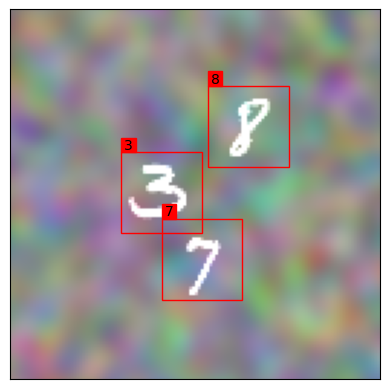

In [7]:
idx = random.randint(0, x_train_det.shape[0])
show_prediction(x_train_det[idx], y_train_det[idx])

##Region Proposal algorithm realization (Selective Search from OpenCV)

In [8]:
def selective_search(image):
    ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
    ss.setBaseImage(image)
    ss.switchToSelectiveSearchFast()
    rects = ss.process()    #[x, y, w, h]
    x_min, y_min, w, h = tf.unstack(rects, axis=1)
    rects = tf.stack([x_min, y_min, x_min+w, y_min+h], axis=1)  #[x_min, y_min, x_max, y_max]
    return rects.numpy().tolist()

In [9]:
def intersection_over_union(gt_boxes, pred_boxes):
    # given [x_min, y_min, x_max, y_max]
	# determine the (x, y)-coordinates of the intersection rectangle
    x_min_inter = max(gt_boxes[0], pred_boxes[0])
    y_min_inter = max(gt_boxes[1], pred_boxes[1])
    x_max_inter = min(gt_boxes[2], pred_boxes[2])
    y_max_inter = min(gt_boxes[3], pred_boxes[3])
	# compute the area of intersection rectangle
    inter_area = max(0, x_max_inter - x_min_inter + 1) * max(0, y_max_inter - y_min_inter + 1)
	# compute the area of both the prediction and ground-truth rectangles
    box_gt_area = (gt_boxes[2] - gt_boxes[0] + 1) * (gt_boxes[3] - gt_boxes[1] + 1)
    box_pred_area = (pred_boxes[2] - pred_boxes[0] + 1) * (pred_boxes[3] - pred_boxes[1] + 1)
	# compute the intersection over union by taking the intersection
	# area and dividing it by the sum of prediction + ground-truth
	# areas - the interesection area
    iou = inter_area / float(box_gt_area + box_pred_area - inter_area)
	# return the intersection over union value
    return iou

def iou_scores(gt_boxes, pred_boxes):
    scores = []
    for pred_box in pred_boxes:
        iou = []
        for gt_box in gt_boxes:
            iou.append(intersection_over_union(gt_box[1:], pred_box))
        scores.append(max(iou))
    return scores

In [10]:
def non_max_suppression(bboxes, scores, max_output_size=20, threshold=0.5, alpha=0.5):
    bboxes = tf.cast(bboxes, dtype=tf.float32)
    x_min, y_min, x_max, y_max = tf.unstack(bboxes,axis=1)
    bboxes = tf.stack([y_min, x_min, y_max, x_max],axis=1)
    score_threshold = max(scores)*alpha
    bbox_indices = tf.image.non_max_suppression(bboxes,
                                                scores,
                                                max_output_size=max_output_size,
                                                iou_threshold=threshold,
                                                score_threshold=score_threshold)
    filtered_bboxes = tf.gather(bboxes, bbox_indices)

    y_min, x_min, y_max, x_max = tf.unstack(filtered_bboxes, axis=1)
    filtered_bboxes = tf.stack([x_min, y_min, x_max, y_max], axis=1)
    return filtered_bboxes

In [11]:
def show_proposals(img, proposals):
    fig, ax = plt.subplots(1)
    ax.imshow(img, vmin=0, vmax=1)
    for proposal in proposals:
        x_min, y_min, x_max, y_max = proposal
        rect = patches.Rectangle((x_min, y_min),
                                 x_max-x_min,
                                 y_max-y_min,
                                 linewidth=1,
                                 edgecolor='r',
                                 facecolor='none')
        ax.set(xticks=[], yticks=[])
        ax.add_patch(rect)

In [12]:
def show_pred_bboxes(image, bboxes, n=10):
    img = image.copy()
    if len(bboxes) < n:
        n = len(bboxes)
    for i in range(n):
        x, y = bboxes[i][0], bboxes[i][1]
        w, h = bboxes[i][0]+bboxes[i][2], bboxes[i][1]+bboxes[i][3]
        cv2.rectangle(img, (x, y), (w, h), (255, 0, 0), 1, cv2.LINE_AA)
    cv2_imshow(img*255)

###Testing Region Proposal algorithm

Test image


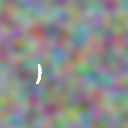

Number of rectangles found: 137
Display them on the image


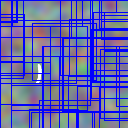

Number of filtered b-boxes: 4


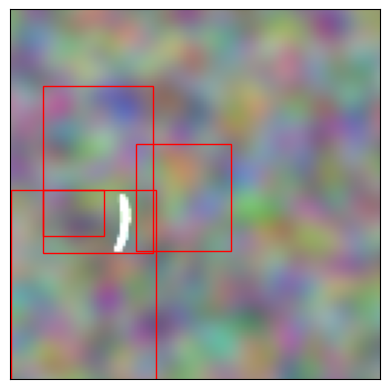

In [13]:
idx = random.randint(0, x_train_det.shape[0])
print('Test image')
cv2_imshow(x_train_det[idx]*255)

test_rects = selective_search(x_train_det[idx])
print(f'Number of rectangles found: {len(test_rects)}')
print(f'Display them on the image')
show_pred_bboxes(x_train_det[idx], test_rects, n=50)

num_area = x_train.shape[1] * x_train.shape[2]
test_scores = iou_scores(y_train_det[idx], test_rects)
proposals = non_max_suppression(test_rects,
                                test_scores,
                                threshold=0.2,
                                max_output_size=30,
                                alpha=0.5)
print(f'Number of filtered b-boxes: {len(proposals)}')
show_proposals(x_train_det[idx], proposals)

##Getting proposals for whole dataset (train and test)

In [14]:
def get_all_proposals(data, labels):
    all_proposals = []
    for idx in range(len(data)):
        if idx % int(len(data)/4) == 0:
            print(f'[{idx} / {len(data)}]')
        rects = selective_search(data[idx])
        scores = iou_scores(labels[idx], rects)
        rects = non_max_suppression(rects,
                                    scores,
                                    threshold=0.2,
                                    max_output_size=30,
                                    alpha=0.5)
        all_proposals.append(rects.numpy().astype(np.int32))
    print(f'Shape: {len(all_proposals)}')
    return np.array(all_proposals)

In [15]:
num_area = x_train.shape[1] * x_train.shape[2]

train_proposals = get_all_proposals(x_train_det, y_train_det)
test_proposals = get_all_proposals(x_test_det, y_test_det)

[0 / 10000]
[2500 / 10000]
[5000 / 10000]
[7500 / 10000]
Shape: 10000
[0 / 2000]


<ipython-input-14-d182f289cd41>:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(all_proposals)


[500 / 2000]
[1000 / 2000]
[1500 / 2000]
Shape: 2000


##Create classification dataset based on object detection dataset

In [16]:
def get_classification_dataset(x_det, y_det, inp_size, bg_source, bg_samples_num):
    imgs = []
    labels = []
    for idx in range(len(x_det)):
        if idx % int(len(x_det)/4) == 0:
            print(f'[{idx} / {len(x_det)}]')
        img = x_det[idx]
        for box in y_det[idx]:
            pred_cls = box[0]
            x_min, y_min, x_max, y_max = box[1:]
            img_sub = img[y_min:y_max, x_min:x_max, :]
            if img_sub.shape[0] == inp_size[0] and img_sub.shape[1] == inp_size[1]:
                img_inp = img_sub
            else:
                img_inp = skimage.transform.resize(img_sub,
                 (inp_size[0], inp_size[1]), order=3, mode='reflect', anti_aliasing=True)
            imgs.append(img_inp)
            labels.append(pred_cls)

    for i in range(bg_samples_num):
        if i % int(bg_samples_num/4) == 0:
            print(f'[{i} / {bg_samples_num}]')
        ofs = (random.randint(0, bg_source.shape[0]-inp_size[0]),
               random.randint(0, bg_source.shape[1]-inp_size[1]))
        imgs.append(bg_source[ofs[0]:ofs[0]+inp_size[0], ofs[1]:ofs[1]+inp_size[1], :])
        labels.append(10) # bg

    x_cls = np.stack(imgs)
    y_cls = np.stack(labels)
    print(f'Out shape: {x_cls.shape}, {y_cls.shape}')
    return x_cls, y_cls

In [17]:
inp_size = (28, 28) # Размер входа в нейросеть

x_train_cls, y_train_cls = get_classification_dataset(x_train_det,
                                                      y_train_det,
                                                      inp_size,
                                                      bg_source,
                                                      bg_samples_num=len(x_train_det))
x_test_cls, y_test_cls = get_classification_dataset(x_test_det,
                                                    y_test_det,
                                                    inp_size,
                                                    bg_source,
                                                    bg_samples_num=len(x_test_det))

[0 / 10000]
[2500 / 10000]
[5000 / 10000]
[7500 / 10000]
[0 / 10000]
[2500 / 10000]
[5000 / 10000]
[7500 / 10000]
Out shape: (40080, 28, 28, 3), (40080,)
[0 / 2000]
[500 / 2000]
[1000 / 2000]
[1500 / 2000]
[0 / 2000]
[500 / 2000]
[1000 / 2000]
[1500 / 2000]
Out shape: (8031, 28, 28, 3), (8031,)


##Create RCNN model

In [59]:
class RCNNModel(tf.keras.Model):
    def __init__(self, num_classes):
        super(RCNNModel, self).__init__()
        self.conv1_1 = tf.keras.layers.Conv2D(32, (5,5), activation='relu', padding='same', input_shape=(28,28,3))
        self.conv1_2 = tf.keras.layers.Conv2D(32, (5,5), activation='relu', padding='same')
        self.conv2_1 = tf.keras.layers.Conv2D(64, (5,5), activation='relu', padding='same')
        self.conv2_2 = tf.keras.layers.Conv2D(64, (5,5), activation='relu', padding='same')
        self.conv3_1 = tf.keras.layers.Conv2D(128, (5,5), activation='relu', padding='same')
        self.conv3_2 = tf.keras.layers.Conv2D(128, (5,5), activation='relu', padding='same')
        self.dense1 = tf.keras.layers.Dense(256, activation='relu')
        self.dense2 = tf.keras.layers.Dense(num_classes, activation='softmax')
        self.flat = tf.keras.layers.Flatten()
        self.maxpool = tf.keras.layers.MaxPooling2D((2,2), (2,2), padding='same')
        self.dropout = tf.keras.layers.Dropout(0.25)
        self.batchnorm_1_1 = tf.keras.layers.BatchNormalization()
        self.batchnorm_1_2 = tf.keras.layers.BatchNormalization()
        self.batchnorm_2_1 = tf.keras.layers.BatchNormalization()
        self.batchnorm_2_2 = tf.keras.layers.BatchNormalization()
        self.batchnorm_3_1 = tf.keras.layers.BatchNormalization()
        self.batchnorm_3_2 = tf.keras.layers.BatchNormalization()

    def call(self, inp):
        out = self.conv1_1(inp)
        out = self.batchnorm_1_1(out)
        out = self.conv1_2(out)
        out = self.batchnorm_1_2(out)
        out = self.dropout(out)
        out = self.maxpool(out)
        out = self.conv2_1(out)
        out = self.batchnorm_2_1(out)
        out = self.conv2_2(out)
        out = self.batchnorm_2_2(out)
        out = self.dropout(out)
        out = self.maxpool(out)
        out = self.conv3_1(out)
        out = self.batchnorm_3_1(out)
        out = self.conv3_2(out)
        out = self.batchnorm_3_2(out)
        out = self.dropout(out)
        out = self.maxpool(out)
        out = self.flat(out)
        out = self.dense1(out)
        out = self.dense2(out)

        return out

In [19]:
def plot_acc_loss(history):
    plt.figure(figsize=(10,3))
    plt.subplot(1,2,1)
    plt.plot(range(EPOCHS), history.history['accuracy'], label='Train')
    plt.plot(range(EPOCHS), history.history['val_accuracy'], label='Validation')
    plt.title('Accuracy')
    plt.legend(loc='lower right')

    plt.subplot(1,2,2)
    plt.plot(range(EPOCHS), history.history['loss'], label='Train')
    plt.plot(range(EPOCHS), history.history['val_loss'], label='Validation')
    plt.title('Loss')
    plt.legend(loc='upper right')

##RCNN training

Epoch 1/20
627/627 [==============================] - 13s 15ms/step - loss: 0.3050 - accuracy: 0.9220 - val_loss: 1.0402 - val_accuracy: 0.7647
Epoch 2/20
627/627 [==============================] - 9s 14ms/step - loss: 0.0957 - accuracy: 0.9716 - val_loss: 0.5683 - val_accuracy: 0.8847
Epoch 3/20
627/627 [==============================] - 9s 14ms/step - loss: 0.1012 - accuracy: 0.9787 - val_loss: 0.0894 - val_accuracy: 0.9743
Epoch 4/20
627/627 [==============================] - 9s 14ms/step - loss: 0.0640 - accuracy: 0.9834 - val_loss: 0.1012 - val_accuracy: 0.9766
Epoch 5/20
627/627 [==============================] - 9s 15ms/step - loss: 0.0443 - accuracy: 0.9882 - val_loss: 1.5600 - val_accuracy: 0.8140
Epoch 6/20
627/627 [==============================] - 9s 14ms/step - loss: 0.0351 - accuracy: 0.9895 - val_loss: 0.1188 - val_accuracy: 0.9757
Epoch 7/20
627/627 [==============================] - 9s 14ms/step - loss: 0.0285 - accuracy: 0.9913 - val_loss: 0.1070 - val_accuracy: 0.978

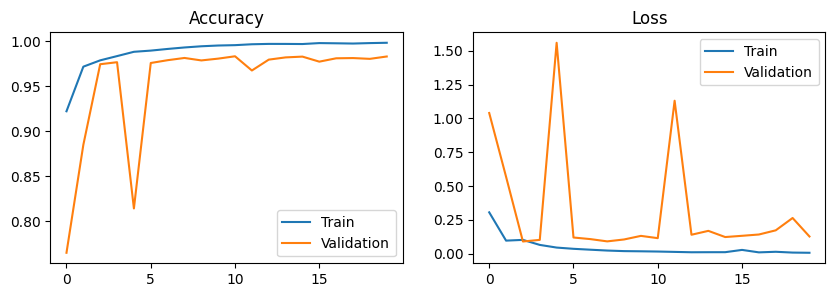

In [60]:
NUM_CLASSES = 11
EPOCHS = 20
BATCH_SIZE = 64

rcnn_model = RCNNModel(NUM_CLASSES)

loss = tf.keras.losses.SparseCategoricalCrossentropy()
rcnn_model.compile(optimizer='rmsprop', loss=loss, metrics=['accuracy'])

hist = rcnn_model.fit(x_train_cls,
                      y_train_cls,
                      validation_data=(x_test_cls, y_test_cls),
                      epochs=EPOCHS,
                      batch_size=BATCH_SIZE
                      )

plot_acc_loss(hist)

##Testing proposal input for RCNN

1/1 [==============================] - 0s 337ms/step


5

<Figure size 640x480 with 0 Axes>

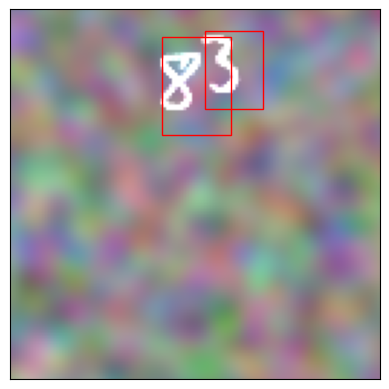

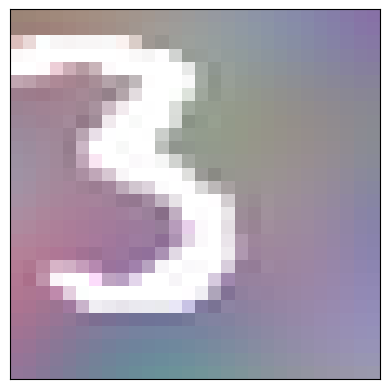

In [46]:
inp_size = (28, 28)

idx = random.randint(0, len(x_test_det)-1)
img = x_test_det[idx]
proposals_img = test_proposals[idx]
proposal = proposals_img[0]

x_min, y_min, x_max, y_max = proposal
img_sub = img[y_min:y_max, x_min:x_max, :]
img_inp = skimage.transform.resize(img_sub, (inp_size[0], inp_size[1]),
    order=3, mode='reflect', anti_aliasing=True)

plt.figure()
show_proposals(img, proposals_img)

plt.figure()
plt.xticks([])
plt.yticks([])
plt.imshow(img_inp, vmin=0, vmax=1,)
np.argmax(rcnn_model.predict(img_inp[None, ...])[0])

##Run Object Detection with R-CNN

In [47]:
def rcnn_prediction(img, proposals_img, inp_size):
    detections = []
    for proposal in proposals_img:
        x_min, y_min, x_max, y_max = proposal
        img_sub = img[y_min:y_max, x_min:x_max, :]
        img_inp = skimage.transform.resize(img_sub, (inp_size[0], inp_size[1]),
                                           order=3, mode='reflect', anti_aliasing=True)
        pred = np.argmax(rcnn_model.predict(img_inp[None, ...])[0])
        if pred != 10:
            detections.append([pred, x_min, y_min, x_max, y_max])
    return detections

1/1 [==============================] - 0s 27ms/step


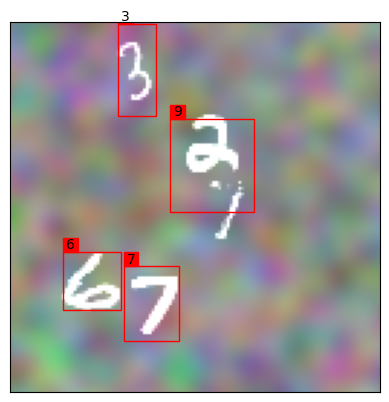

In [66]:
idx = np.random.randint(0, len(x_test_det)-1)
preds = rcnn_prediction(x_test_det[idx], test_proposals[idx], (28, 28))

# show_prediction(x_test_det[idx], y_test_det[idx])
# show_proposals(x_test_det[idx], test_proposals[idx])
show_prediction(x_test_det[idx], preds)